In [1]:
"""author: Vetivert? 💐 
created: 15/05/2025 @ 04:26:51"""

'author: Vetivert? 💐 \ncreated: 15/05/2025 @ 04:26:51'

# LOAD DATA

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.preprocessing import StandardScaler, label_binarize 
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score, 
                             mean_squared_error, r2_score, roc_auc_score, make_scorer) 
from sklearn.ensemble import RandomForestClassifier 
from scipy.stats import randint, uniform 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import lightgbm as lgb

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
# from src.utils.models import *
from src.utils.functions import *

In [34]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)



Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': np.float64(56.4), '2': np.float64(39.66), '3': np.float64(3.94)}


/tmp/ipykernel_38817/2143648380.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('8(nặng xin về)', 8)
/tmp/ipykernel_38817/2143648380.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
/tmp/ipykernel_38817/2143648380.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

# LightGBM

In [41]:
df.drop(HEART_INDEX, axis=1, inplace=True)

In [42]:
df_set = df.loc[:, 'Gende':'Oliguria'].copy().fillna(0)
df_set = df_set.apply(pd.to_numeric, errors='coerce')

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set, df['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df['Diagnosis'])
x1_features = x1_train.columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (324, 21) y1_train shape:  (324,)
x1_test shape:  (82, 21) y1_test shape:  (82,)
percentage of classes:  {'1': np.float64(56.1), '2': np.float64(43.9)}


In [43]:
x1_train

,Gende,DHF infection His.,additional_diseases,Fever,Bleeding,Fatigue,Day of illness,Level of temp,Duration fever,Headache,...,Rash,hematoma,Mucosa membrane bleeding,Pleural effusion,Ascites,Pericardial effusion,Vomiting,Abdominal pain or tendness,Liver enlargement,Oliguria
20,0,0,0,1,0,0,3,0,0,1,...,0,1,0,0,0,0,0,0,0,0
13,1,0,1,1,0,1,3,0,0,1,...,0,1,1,0,0,0,0,0,0,0
81,1,0,1,1,0,1,7,0,0,1,...,0,1,1,0,0,0,0,0,0,0
363,1,0,0,1,0,1,2,3,4,1,...,0,0,0,0,0,0,0,0,0,0
401,0,0,1,1,1,1,4,2,6,1,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,0,0,0,1,1,1,6,3,6,1,...,0,1,0,0,0,0,0,0,0,0
203,0,0,0,1,1,1,4,0,0,1,...,0,0,1,0,0,0,0,0,0,0
134,1,0,1,1,0,0,3,3,3,1,...,0,1,1,0,0,0,0,0,0,0
388,0,0,0,1,0,1,1,3,3,1,...,0,1,0,0,0,0,0,0,0,0


In [44]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,  # Lower learning rate
    max_depth=3,         # Lower max depth
    min_child_samples=5, # Require more samples in leaf nodes
    min_child_weight=1,
    subsample=0.8,       # Use 80% of samples per tree
    colsample_bytree=0.8, # Use 80% of features per tree
    reg_alpha=0.1,       # L1 regularization
    reg_lambda=0.1,      # L2 regularization
    random_state=42,
    verbose=-1           # Reduce verbosity
)

lgb_model.fit(x1_train, y1_train)
y_pred_lgb = lgb_model.predict(x1_test)

print("LightGBM Report:\n", classification_report(np.asarray(y1_test), np.asarray(y_pred_lgb)))

LightGBM Report:
               precision    recall  f1-score   support

           1       0.70      0.83      0.76        46
           2       0.71      0.56      0.62        36

    accuracy                           0.71        82
   macro avg       0.71      0.69      0.69        82
weighted avg       0.71      0.71      0.70        82



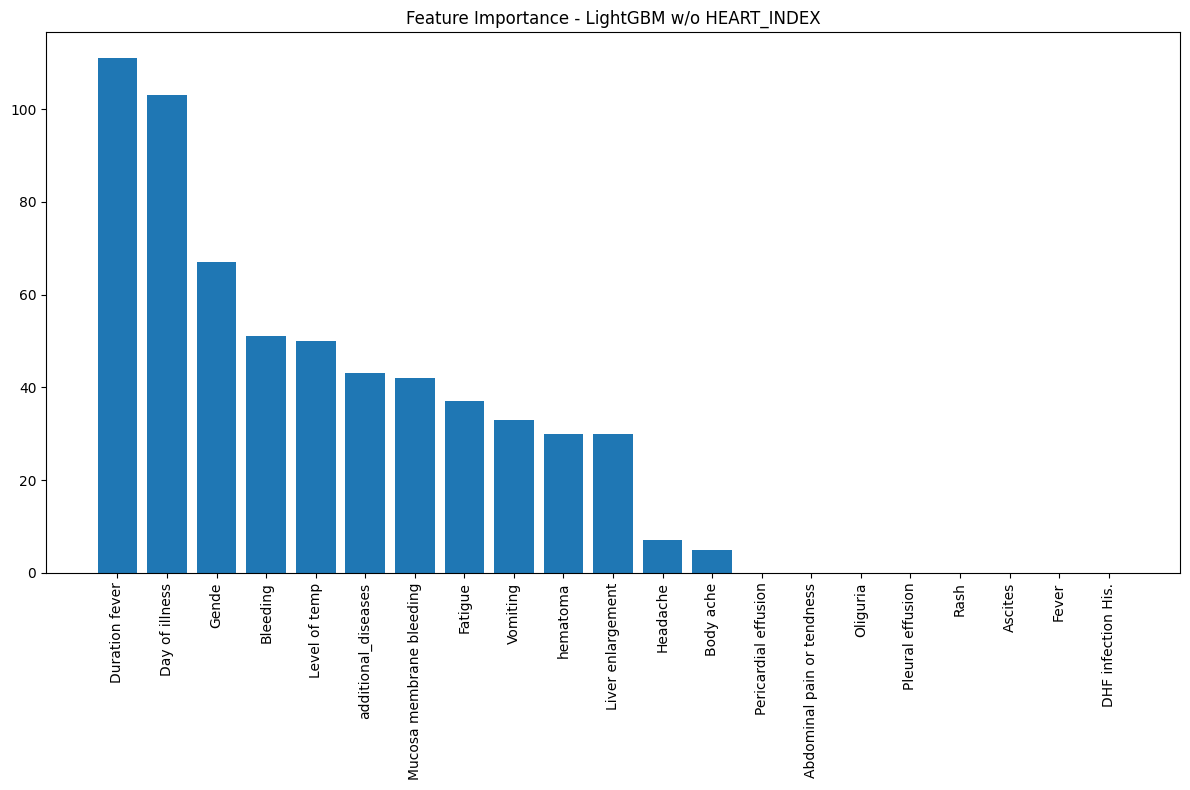

Features with zero importance: 8
['DHF infection His.', 'Fever', 'Rash', 'Pleural effusion', 'Ascites', 'Pericardial effusion', 'Abdominal pain or tendness', 'Oliguria'] 


In [45]:
def plot_feature_importance(model, feature_names):
    # Get feature importance
    importance = model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importance)[::-1]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance - LightGBM w/o HEART_INDEX')
    plt.bar(range(len(indices)), importance[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Return features with zero importance
    zero_features = [feature_names[i] for i, imp in enumerate(importance) if imp == 0]
    if zero_features:
        print(f"Features with zero importance: {len(zero_features)}")
        print(zero_features[:10], "..." if len(zero_features) > 10 else "")
    
    return indices, importance

# After training
feature_indices, importances = plot_feature_importance(lgb_model, x1_train.columns)



In [47]:
# Remove features with zero importance
important_features = [x1_train.columns[i] for i in feature_indices if importances[i] > 0]
print(f"Keeping {len(important_features)} important features out of {len(x1_train.columns)}")

# Retrain with only important features
x1_train_important = x1_train[important_features]
x1_test_important = x1_test[important_features]

# Train new model with important features
# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, -1],  # -1 means no limit
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1), # type: ignore
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit random search
random_search.fit(x1_train_important, y1_train)

Keeping 13 important features out of 21


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [2, 3, 4, 5, -1],
                                        'min_child_samples': [5, 10, 20, 50],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1_weighted')

In [49]:
# Get best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Train final model with best parameters
best_lgb_model = lgb.LGBMClassifier(**random_search.best_params_, random_state=42)
best_lgb_model.fit(x1_train_important, y1_train)

Best Parameters: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best Score: 0.7344531205150827


LGBMClassifier(colsample_bytree=0.6, max_depth=3, min_child_samples=5,
               random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=0.6)

In [50]:
y_pred_best_lgb = best_lgb_model.predict(x1_test_important)

print("LightGBM Report:\n", classification_report(np.asarray(y1_test), np.asarray(y_pred_best_lgb)))

LightGBM Report:
               precision    recall  f1-score   support

           1       0.73      0.87      0.79        46
           2       0.78      0.58      0.67        36

    accuracy                           0.74        82
   macro avg       0.75      0.73      0.73        82
weighted avg       0.75      0.74      0.74        82

